In [1]:
import sys
import subprocess

#import pkg_resources
#required = {'harmonypy','sklearn','scanpy','pandas', 'numpy', 'bbknn', 'scipy', 'matplotlib', 'seaborn' ,'scipy'}
#installed = {pkg.key for pkg in pkg_resources.working_set}
#missing = required - installed
#if missing:
#    print("Installing missing packages:" )
#    print(missing)
#    python = sys.executable
#    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

%matplotlib inline
from collections import Counter
from collections import defaultdict
import scanpy as sc
import pandas as pd
import pickle as pkl
import numpy as np
from bbknn import bbknn
import scipy
import matplotlib.pyplot as plt
import re
import glob
import os
import sys
from geosketch import gs
from numpy import cov
import scipy.cluster.hierarchy as spc
import seaborn as sns; sns.set(color_codes=True)
from sklearn.linear_model import LogisticRegression
import sklearn
import harmonypy as hm
from pathlib import Path
import scrublet as scr

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')

In [2]:
# ys_fliv

Object = '/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/A4_V7_Combined_YS_Fliver_20210914.h5ad'
# Required: Name of first object
data2 = "_ys"
# Provide categorical to join between datasets
cat2 = "cell.labels"
# Required: Name of second object
data1 = "_fliv"
# Provide categorical to join between datasets
cat1 = "cell.labels"
import os
adata = sc.read(Object)
adata.obs.columns
obs = pd.read_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/YS_Reprocess_250721_updates/Combined_YS_Fliver_meta_20210929.csv',index_col=0)
adata.obs = obs
common_cat = "corr_concat" 
adata.obs[common_cat] = "corr_concat"
adata.obs.loc[adata.obs['tissue'].isin(['YS']),common_cat] = adata.obs.loc[adata.obs['tissue'].isin(['YS']),cat1].astype(str) + data2
adata.obs.loc[adata.obs['tissue'].isin(['Liver']),common_cat] = adata.obs.loc[adata.obs['tissue'].isin(['Liver']),cat2].astype(str) + data1
adata.obs["lr_batch"]  = adata.obs["tissue"].astype(str) + '_' +  adata.obs['fetal.ids'].astype(str)

In [3]:
# adata = sc.read('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_090321_notebooks/YS_Reprocess_250721_updates/mouse_gastrulation_human_YS_combination/adata_ms_diff.h5ad')

In [4]:
# del adata.obsm['X_umap']

In [5]:
# sc.pl.draw_graph(adata,color = 'predicted')

In [2]:
# just_ys
adata = sc.read('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/A4_V8_YS_integrated_data_singlets_with_raw_counts_for_MS_plotting_20220328_with_obsp.h5ad')

In [3]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

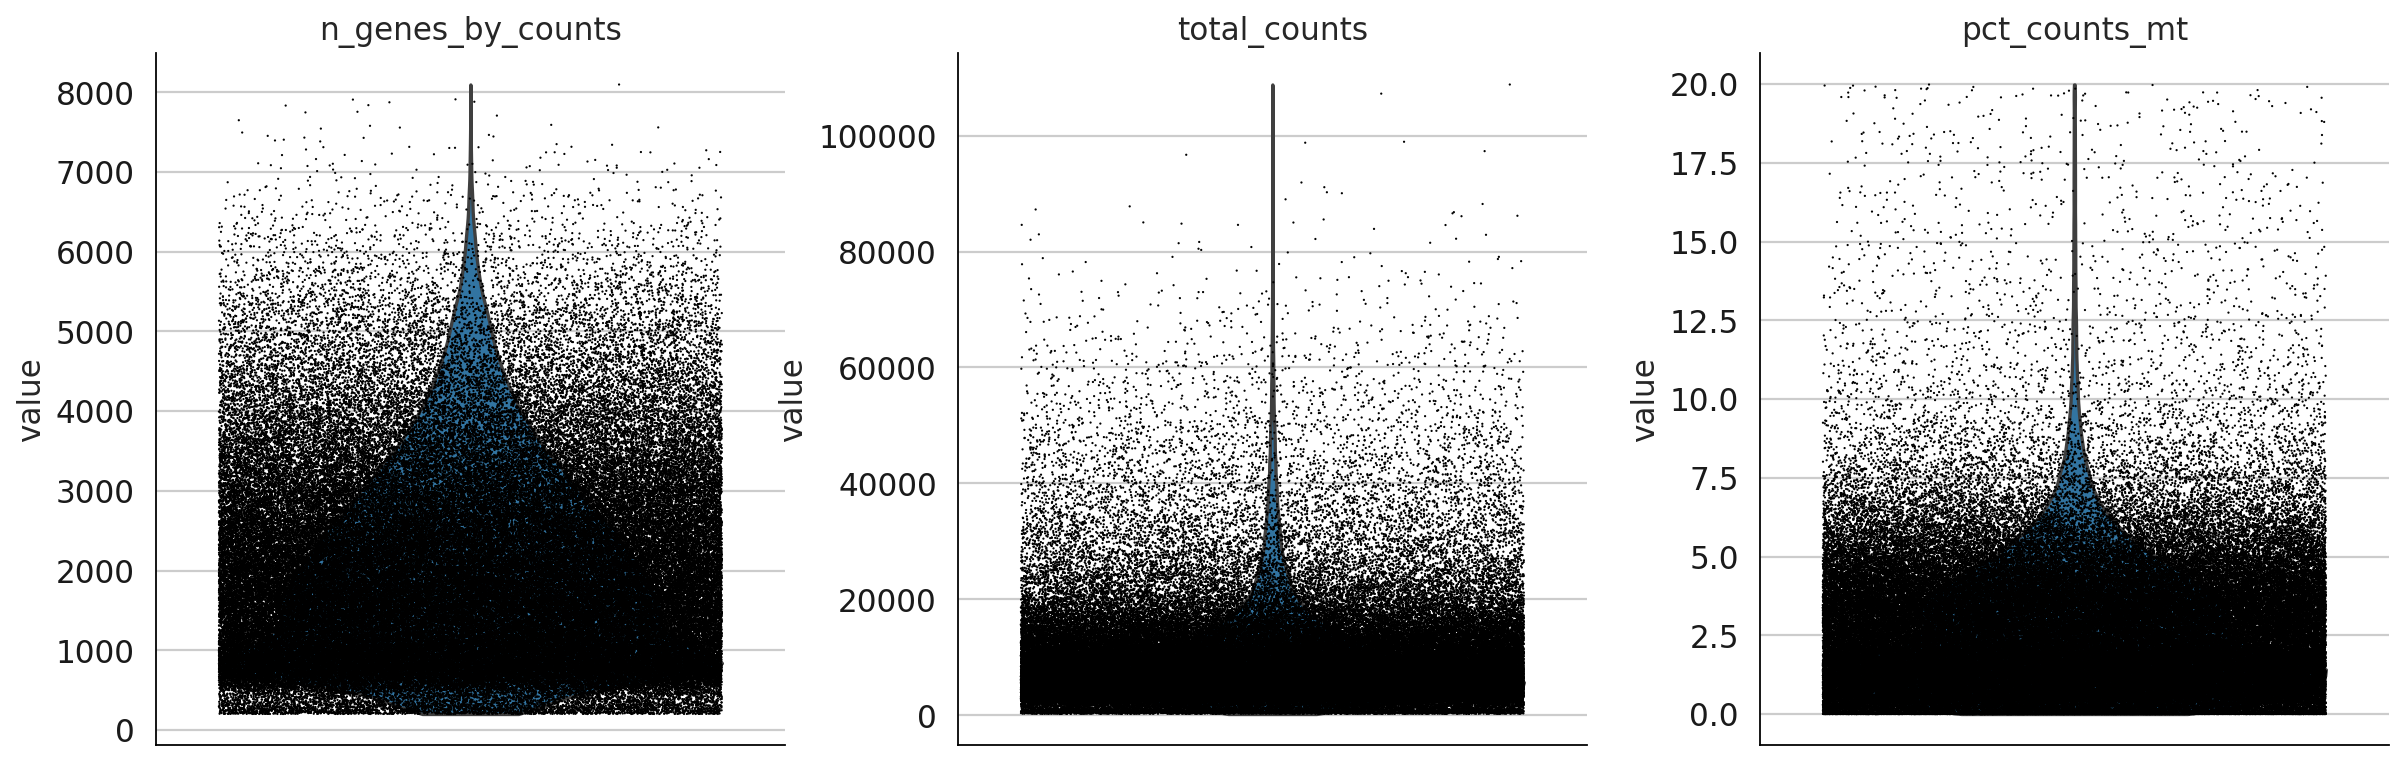

In [4]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

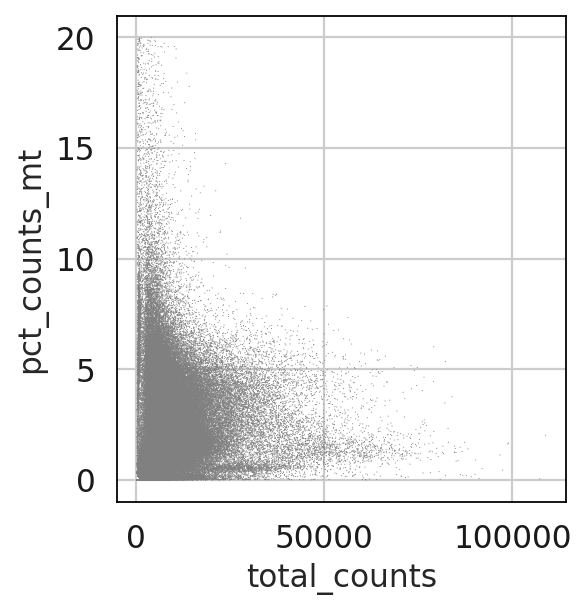

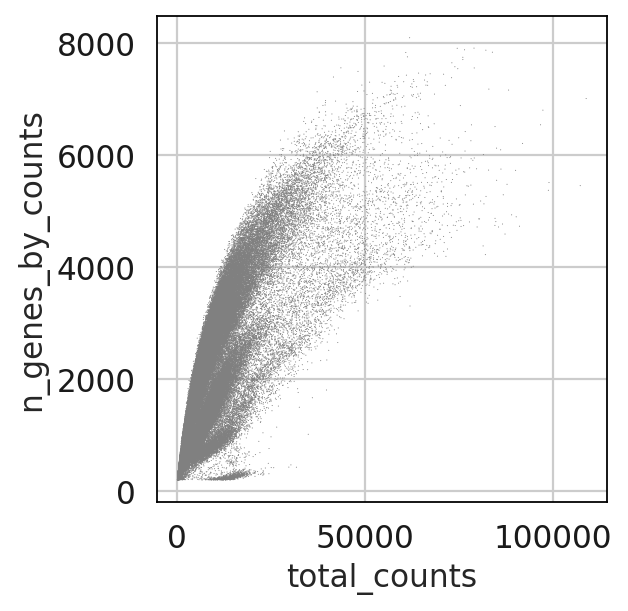

In [5]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [6]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
# adata = adata[adata.obs.n_genes_by_counts < 5000, :]
adata = adata[adata.obs.pct_counts_mt < 20, :]

filtered out 13 genes that are detected in less than 3 cells


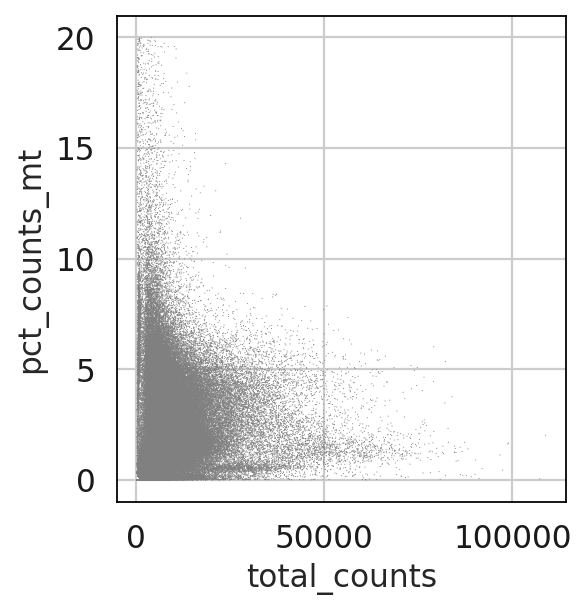

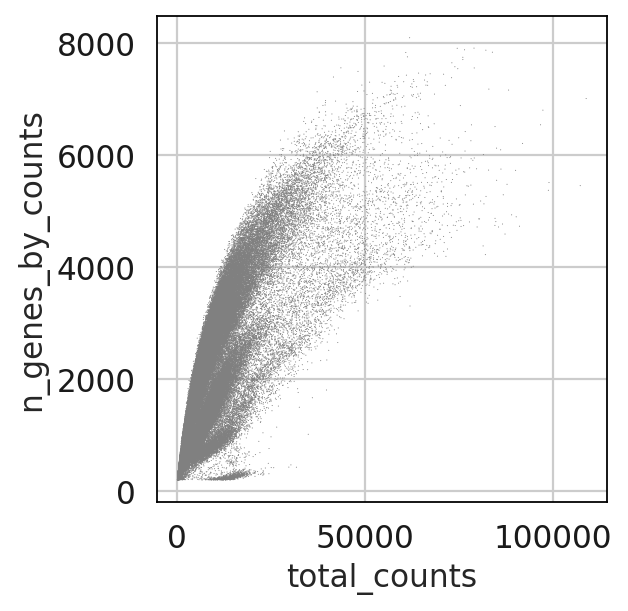

In [7]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [8]:
np.max(adata.X)

19361.0

In [9]:
adata.obs

cell.labels stage  \
Wang_et_al_AAACCTGAGACCTTTG_1                       Sinusoidal_EC  CS10   
Wang_et_al_AAACCTGCACCTATCC_1                                MEMP  CS10   
Wang_et_al_AAACCTGCACTTAAGC_1                              HSPC_1  CS10   
Wang_et_al_AAACCTGGTAACGACG_1                           Erythroid  CS10   
Wang_et_al_AAACCTGGTCAAAGAT_1                           Erythroid  CS10   
...                                                           ...   ...   
F80_Yolksac_CD45NAF_FCAImmP8096696_TTTGGTTCATCC...      Erythroid  CS15   
F80_Yolksac_CD45NAF_FCAImmP8096696_TTTGTCAAGATG...    Immature_EC  CS15   
F80_Yolksac_CD45NAF_FCAImmP8096696_TTTGTCAGTCGA...    Immature_EC  CS15   
F80_Yolksac_CD45NAF_FCAImmP8096696_TTTGTCATCATT...      Erythroid  CS15   
F80_Yolksac_CD45NAF_FCAImmP8096696_TTTGTCATCGGA...    Mesothelium  CS15   

                                                             lanes   sex  \
Wang_et_al_AAACCTGAGACCTTTG_1                            Wang_CS10  Male   
Wang_et_al_AAACCTGCACCTATCC_1                            Wang_CS10  Male   
Wang_et_al_AAACCTGCACTTAAGC_1                            Wang_CS10  Male   
Wang_et_al_AAACCTGGTAACGACG_1                            Wang_CS10  Male   
Wang_et_al_AAACCTGGTCAAAGAT_1                            Wang_CS10  Male   
...                                                            ...   ...   
F80_Yolksac_CD45NAF_FCAImmP8096696_TTTGGTTCATCC...  FCAImmP8096696  Male   
F80_Yolksac_CD45NAF_FCAImmP8096696_TTTGTCAAGATG...  FCAImmP8096696  Male   
F80_Yolksac_CD45NAF_FCAImmP8096696_TTTGTCAGTCGA...  FCAImmP8096696  Male   
F80_Yolksac_CD45NAF_FCAImmP8096696_TTTGTCATCATT...  FCAImmP8096696  Male   
F80_Yolksac_CD45NAF_FCAImmP8096696_TTTGTCATCGGA...  FCAImmP8096696  Male   

                                                   sort.ids  fetal.ids  \
Wang_et_al_AAACCTGAGACCTTTG_1                         Total  Wang_CS10   
Wang_et_al_AAACCTGCACCTATCC_1                         Total  Wang_CS10   
Wang_et_al_AAACCTGCACTTAAGC_1                         Total  Wang_CS10   
Wang_et_al_AAACCTGGTAACGACG_1                         Total  Wang_CS10   
Wang_et_al_AAACCTGGTCAAAGAT_1                         Total  Wang_CS10   
...                                                     ...        ...   
F80_Yolksac_CD45NAF_FCAImmP8096696_TTTGGTTCATCC...  CD45NAF        F80   
F80_Yolksac_CD45NAF_FCAImmP8096696_TTTGTCAAGATG...  CD45NAF        F80   
F80_Yolksac_CD45NAF_FCAImmP8096696_TTTGTCAGTCGA...  CD45NAF        F80   
F80_Yolksac_CD45NAF_FCAImmP8096696_TTTGTCATCATT...  CD45NAF        F80   
F80_Yolksac_CD45NAF_FCAImmP8096696_TTTGTCATCGGA...  CD45NAF        F80   

                                                   component  \
Wang_et_al_AAACCTGAGACCTTTG_1                       Membrane   
Wang_et_al_AAACCTGCACCTATCC_1                       Membrane   
Wang_et_al_AAACCTGCACTTAAGC_1                       Membrane   
Wang_et_al_AAACCTGGTAACGACG_1                       Membrane   
Wang_et_al_AAACCTGGTCAAAGAT_1                       Membrane   
...                                                      ...   
F80_Yolksac_CD45NAF_FCAImmP8096696_TTTGGTTCATCC...  Membrane   
F80_Yolksac_CD45NAF_FCAImmP8096696_TTTGTCAAGATG...  Membrane   
F80_Yolksac_CD45NAF_FCAImmP8096696_TTTGTCAGTCGA...  Membrane   
F80_Yolksac_CD45NAF_FCAImmP8096696_TTTGTCATCATT...  Membrane   
F80_Yolksac_CD45NAF_FCAImmP8096696_TTTGTCATCGGA...  Membrane   

                                                   broad_cell.labels  \
Wang_et_al_AAACCTGAGACCTTTG_1                            Endothelium   
Wang_et_al_AAACCTGCACCTATCC_1                            Progenitors   
Wang_et_al_AAACCTGCACTTAAGC_1                            Progenitors   
Wang_et_al_AAACCTGGTAACGACG_1                              Erythroid   
Wang_et_al_AAACCTGGTCAAAGAT_1                              Erythroid   
...                                                              ...   
F80_Yolksac_CD45NAF_FCAImmP8096696_TTTGGTTCATCC...         Erythroid   
F80_Yo

In [10]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.


    finished (0:00:05): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:08:40)


/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: Pe

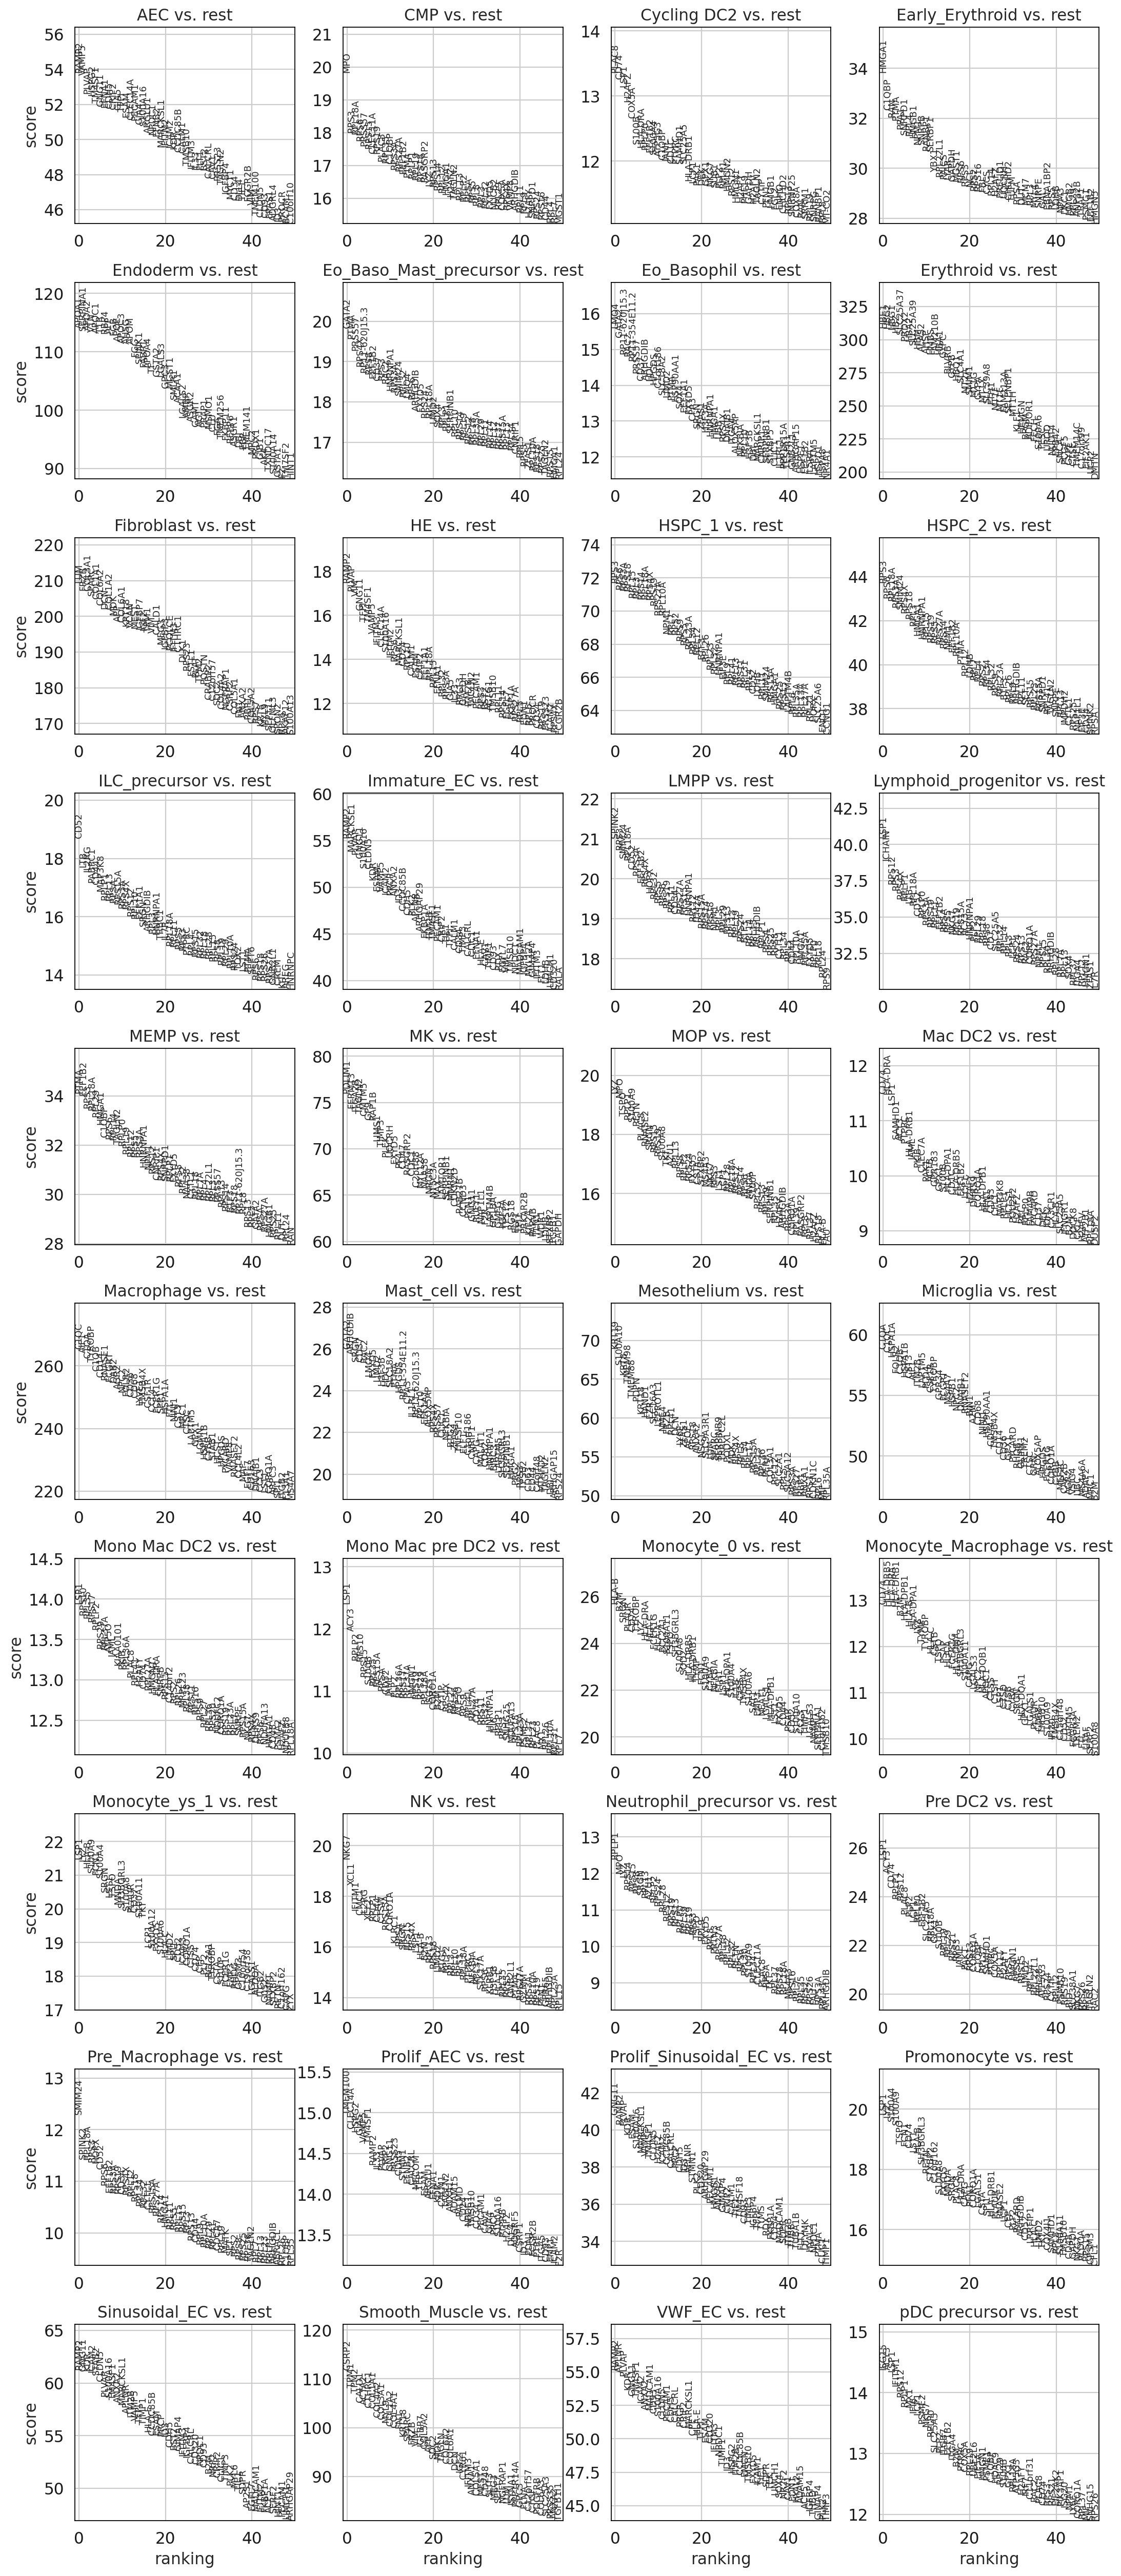

In [11]:
spot_var = 'cell.labels'
sc.tl.rank_genes_groups(adata, spot_var, method='wilcoxon',n_genes=500)
sc.pl.rank_genes_groups(adata, n_genes=50, sharey=False)
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
    
DE = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals_adj','logfoldchanges']}).head(500)
DE_name ="./DEGS_YS_A2_V8_cell_labels_040422.csv"
DE.to_csv(DE_name)
#DE = pd.read_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_310122_notebooks/fig3_Macrophages/Process_IPSC_mac_data/IPSC_DC_lin_use_this/DEGS_DC_v6_mac_lin_QC.csv',index_col=0)
degs = DE[:]
if 'concat' in locals() or 'concat' in globals():
    del(concat)
n = degs.loc[:, degs.columns.str.endswith("_n")]
n = pd.melt(n)
p = degs.loc[:, degs.columns.str.endswith("_p")]
p = pd.melt(p)
l = degs.loc[:, degs.columns.str.endswith("_l")]
l = pd.melt(l)
n = n.replace(regex=r'_n', value='')
n = n.rename(columns={"variable": "cluster", "value": "gene"})
p = (p.drop(["variable"],axis = 1)).rename(columns={ "value": "p_val"})
l = (l.drop(["variable"],axis = 1)).rename(columns={ "value": "logfc"})
concat = pd.concat([n,p,l],axis=1)
#remove mito genes from data
concat = concat[~concat["gene"].str.startswith("MT-")]
concat = concat[~concat["gene"].str.startswith("RP11-")]
concat["cluster"] = concat["cluster"].astype(str)
marker_df = concat.groupby('cluster').apply(lambda grp: grp.nsmallest(50, 'p_val')).reset_index(drop=True)
marker_df = marker_df.groupby('cluster').apply(lambda grp: grp.nlargest(30, 'logfc')).reset_index(drop=True)
markers = marker_df.groupby('cluster')['gene'].apply(list).to_dict()
markers = dict(sorted(markers.items()))
markers = {str(k):v for k,v in markers.items()}
data_temp = adata
markers = markers
marker_df.to_csv('./DEGS_YS_A2_V8_cell_labels_top30_040422.csv')

# Fliv

In [15]:
eliv_adata = sc.read("/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/matched_liver_data/A1.210312_fliv_matched_ys_meta_updated.h5ad")

In [16]:
adata = eliv_adata[:]

In [17]:
tmp = pd.read_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/resources/metadata_A4_V8_eliv_040422.csv',index_col = 0)
adata.obs = tmp

In [18]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

normalizing by total count per cell
    finished (0:00:02): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


ranking genes


/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell.labels' as categorical
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'stage' as categorical
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and 

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmen

    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:02:32)


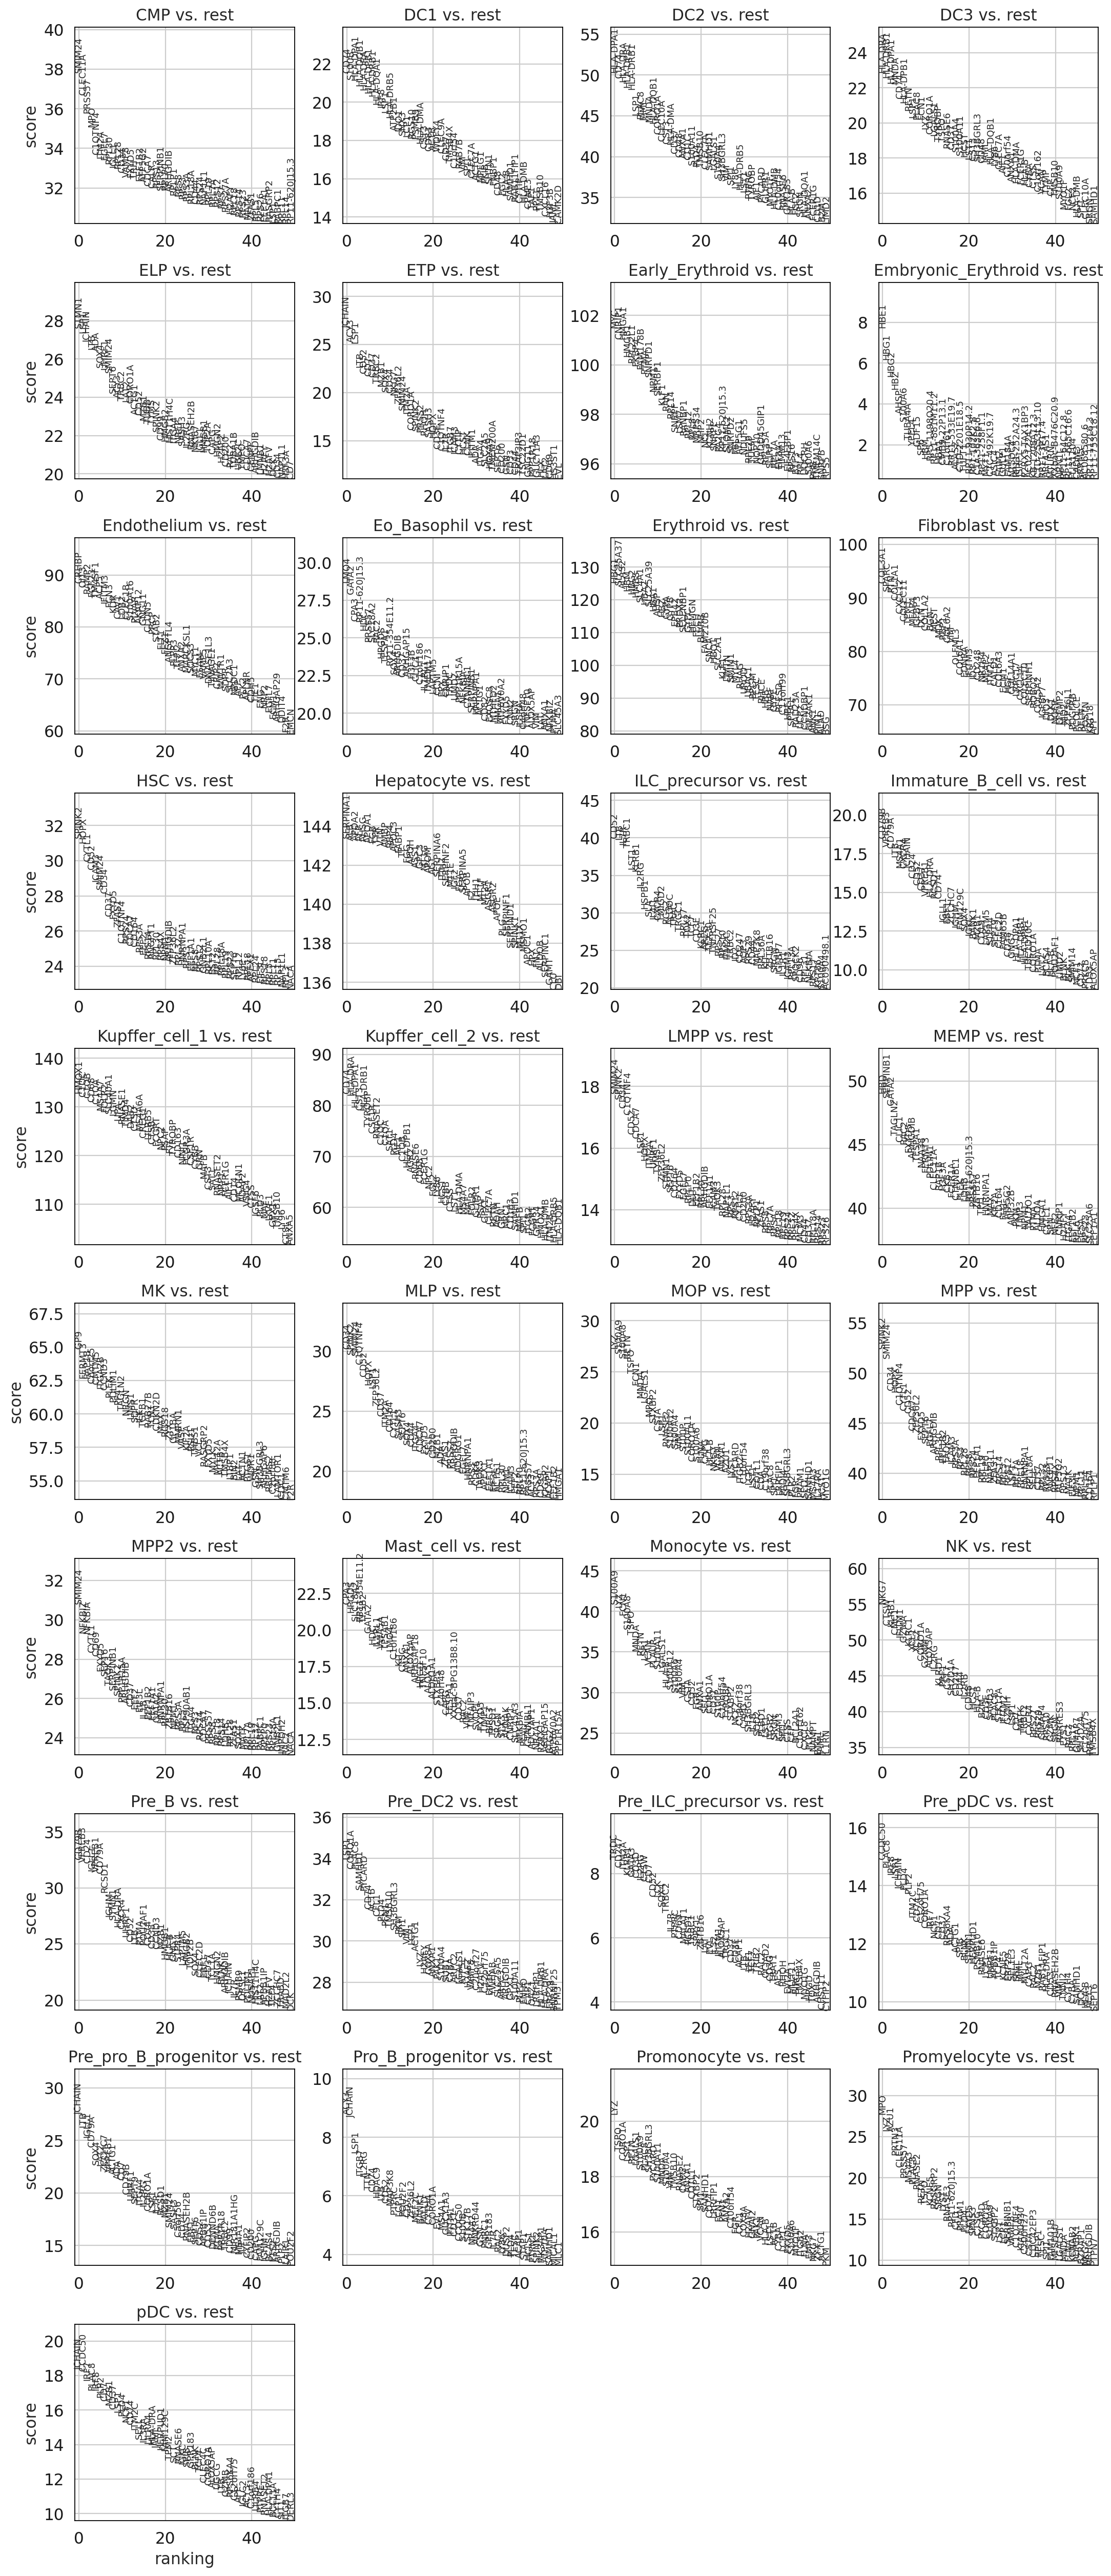

In [19]:
spot_var = 'cell.labels'
sc.tl.rank_genes_groups(adata, spot_var, method='wilcoxon',n_genes=500)
sc.pl.rank_genes_groups(adata, n_genes=50, sharey=False)
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
    
DE = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals','logfoldchanges']}).head(500)
DE_name ="./DEGS_eLIV_A2_V8_cell_labels_040422.csv"
DE.to_csv(DE_name)
#DE = pd.read_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_310122_notebooks/fig3_Macrophages/Process_IPSC_mac_data/IPSC_DC_lin_use_this/DEGS_DC_v6_mac_lin_QC.csv',index_col=0)
degs = DE[:]
if 'concat' in locals() or 'concat' in globals():
    del(concat)
n = degs.loc[:, degs.columns.str.endswith("_n")]
n = pd.melt(n)
p = degs.loc[:, degs.columns.str.endswith("_p")]
p = pd.melt(p)
l = degs.loc[:, degs.columns.str.endswith("_l")]
l = pd.melt(l)
n = n.replace(regex=r'_n', value='')
n = n.rename(columns={"variable": "cluster", "value": "gene"})
p = (p.drop(["variable"],axis = 1)).rename(columns={ "value": "p_val"})
l = (l.drop(["variable"],axis = 1)).rename(columns={ "value": "logfc"})
concat = pd.concat([n,p,l],axis=1)
#remove mito genes from data
concat = concat[~concat["gene"].str.startswith("MT-")]
concat = concat[~concat["gene"].str.startswith("RP11-")]
concat["cluster"] = concat["cluster"].astype(str)
marker_df = concat.groupby('cluster').apply(lambda grp: grp.nsmallest(50, 'p_val')).reset_index(drop=True)
marker_df = marker_df.groupby('cluster').apply(lambda grp: grp.nlargest(30, 'logfc')).reset_index(drop=True)
markers = marker_df.groupby('cluster')['gene'].apply(list).to_dict()
markers = dict(sorted(markers.items()))
markers = {str(k):v for k,v in markers.items()}
data_temp = adata
markers = markers
marker_df.to_csv('./DEGS_eLIV_A2_V8_cell_labels_top30_040422.csv')

In [ ]:
adata.obs.columns

# adata_mye dotplot

In [ ]:
list(adata_mye.obs['cell.labels'].unique())

In [ ]:
adata_mye = adata[:]
adata_mye = adata_mye[adata_mye.obs['cell.labels'].isin([
'HSPC_1',
 'HSPC_2',
 'CMP',
 'MOP',
'Promonocyte',
 'Monocyte_0',
 'Monocyte_ys_1',
 'Monocyte_Macrophage',
 'Pre_Macrophage',
 'Macrophage',
 'Microglia',])]
adata_mye

In [ ]:
adata_mye.obs['cell.labels'] = adata_mye.obs['cell.labels'].astype('category')
adata_mye.obs['cell.labels'] = adata_mye.obs['cell.labels'].cat.reorder_categories([
'HSPC_1',
 'HSPC_2',
 'CMP',
 'MOP',
'Promonocyte',
 'Monocyte_0',
 'Monocyte_ys_1',
 'Monocyte_Macrophage',
 'Pre_Macrophage',
 'Macrophage',
 'Microglia',])

In [ ]:
markers = {
 'HSPC_1': ['SPINK2','MDK', 'BEX3', 'MARCKSL1', 'NPM1', 'EEF2'],
 'HSPC_2': ['MARCKSL1', 'CKS1B', 'HMGB2', 'TUBB', 'HMGB1'],
 'CMP': ['MPO', 'RPS12', 'CLEC11A', 'RPS23', 'RPS6'],
 'MOP': ['AZU1', 'PRTN3', 'LYZ', 'MPO'],
 'Promonocyte': ['FCN1', 'S100A4', 'CST3', 'C1orf162', 'SH3BGRL3'],
 'Monocyte_1': ['S100A8', 'S100A9', 'NCF1', 'MNDA', 'S100A6'],
'Monocyte_2': ['S100A8', 'S100A9', 'NCF1', 'MNDA', 'S100A6'],
 'Monocyte_Macrophage': ['CTSB', 'NPC2', 'LIPA', 'PSAP', 'CSTB'],
 'Pre_Macrophage': ['CD52', 'SMIM24', 'CD34', 'RPL15', 'EEF2'],
 'Macrophage': ['C1QC', 'C1QB', 'DAB2', 'C1QA', 'APOC','MRC1'],
 'Microglia':['TREM2','P2RY12']
}
markers = markers
sc.pl.dotplot(adata_mye, var_names = markers, groupby='cell.labels',dendrogram=False,standard_scale='var', color_map='Reds', show = True, save = 'diff_expression_v6_YS_mye_lin.pdf') # title=i

# IPSC

In [ ]:
adata = sc.read('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_310122_notebooks/fig3_Macrophages/Process_IPSC_mac_data/IPSC_DC_lin_use_this/v6_IPSC_mac_lin.h5ad')

In [39]:
np.max(adata.X)

4.7423835

In [ ]:
adata.obs['LR_assignment_v2'] = adata.obs['LR_assignment_v2'].astype('category')
adata.obs['LR_assignment_v2'] = adata.obs['LR_assignment_v2'].cat.reorder_categories([
'AdvancedMesoderm_IPSC',
'AEC_IPSC',
'HE_IPSC',
'HSPC_1_IPSC',
'HSPC_2_IPSC',
'CMP_IPSC',
'Neutrophil_myeloid_precursor_IPSC',
'MOP_IPSC',
'Promonocyte_IPSC',
'Monocyte_IPSC',
'Monocyte_Macrophage_IPSC',
'Pre_Macrophage_IPSC' ,                                           
'Macrophage_IPSC',])

In [ ]:
markers = {
'AdvancedMesoderm_IPSC': ['KRT8', 'TPM1', 'KRT19', 'MDK', 'KRT18'],
'AEC_IPSC': ['GJA4', 'TFPI', 'RAMP2', 'CLDN5', 'GNG11','IL33'],
 'HE_IPSC': ['VAMP5', 'CLDN5','GJA5', 'KCNK17', 'ALDH1A1'],
 'HSPC_1_IPSC': ['SPINK2','MDK', 'BEX3', 'MARCKSL1', 'NPM1', 'EEF2'],
 'HSPC_2_IPSC': ['MARCKSL1', 'CKS1B', 'HMGB2', 'TUBB', 'HMGB1'],
'CMP_IPSC': ['MPO', 'RPS12', 'CLEC11A', 'RPS23', 'RPS6'],
 'Neutrophil_myeloid_precursor_IPSC': ['AZU1','PRTN3','MPO','MS4A3','CST7'],
 'MOP_IPSC': ['AZU1', 'PRTN3', 'LYZ', 'MPO', 'AC020656.1'],
 'Promonocyte_IPSC': ['FCN1', 'S100A4', 'CST3', 'C1orf162', 'SH3BGRL3'],
 'Monocyte_IPSC': ['S100A8', 'S100A9', 'NCF1', 'MNDA', 'S100A6'],
 'Monocyte_Macrophage_IPSC': ['CTSB', 'NPC2', 'LIPA', 'PSAP', 'CSTB'],
 'Pre_Macrophage_IPSC': ['CD52', 'SMIM24', 'CD34', 'RPL15', 'EEF2'],
 'Macrophage_IPSC': ['C1QC', 'C1QB', 'DAB2', 'C1QA', 'APOC','MRC1'],
}
markers = markers
sc.pl.dotplot(adata, var_names = markers, groupby='LR_assignment_v2',dendrogram=False,standard_scale='var', color_map='Reds', show = True, save = 'diff_expression_v6_mac_lin.pdf') # title=i

In [40]:
# sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
# sc.pp.log1p(adata)

In [41]:
spot_var = 'LR_assignment_v2'
sc.tl.rank_genes_groups(adata, spot_var, method='wilcoxon',n_genes=500)
sc.pl.rank_genes_groups(adata, n_genes=50, sharey=False)
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
    
DE = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals','logfoldchanges']}).head(500)
DE_name ="./DEGS_YS_A2_V8.csv"
DE.to_csv(DE_name)
#DE = pd.read_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_310122_notebooks/fig3_Macrophages/Process_IPSC_mac_data/IPSC_DC_lin_use_this/DEGS_DC_v6_mac_lin_QC.csv',index_col=0)
degs = DE[:]
if 'concat' in locals() or 'concat' in globals():
    del(concat)
n = degs.loc[:, degs.columns.str.endswith("_n")]
n = pd.melt(n)
p = degs.loc[:, degs.columns.str.endswith("_p")]
p = pd.melt(p)
l = degs.loc[:, degs.columns.str.endswith("_l")]
l = pd.melt(l)
n = n.replace(regex=r'_n', value='')
n = n.rename(columns={"variable": "cluster", "value": "gene"})
p = (p.drop(["variable"],axis = 1)).rename(columns={ "value": "p_val"})
l = (l.drop(["variable"],axis = 1)).rename(columns={ "value": "logfc"})
concat = pd.concat([n,p,l],axis=1)
#remove mito genes from data
concat = concat[~concat["gene"].str.startswith("MT-")]
concat = concat[~concat["gene"].str.startswith("RP11-")]
concat["cluster"] = concat["cluster"].astype(str)
marker_df = concat.groupby('cluster').apply(lambda grp: grp.nsmallest(5, 'p_val')).reset_index(drop=True)
markers = marker_df.groupby('cluster')['gene'].apply(list).to_dict()
markers = dict(sorted(markers.items()))
markers = {str(k):v for k,v in markers.items()}
data_temp = adata
markers = markers

# # markers = {
# #  'AdvancedMesoderm_IPSC': ['KRT19', 'HAND1', 'HAPLN1', 'ACTC1', 'BMP4'],
# # 'AEC_IPSC': ['GJA4', 'TFPI', 'RAMP2', 'CLDN5', 'ESAM'],
# #  'CMP_IPSC': ['MPO', 'CLEC11A', 'ARHGDIB', 'VAMP8', 'CFD'],
# #  'HE_IPSC': ['VAMP5', 'TFPI', 'RAMP2', 'GNG11', 'CLDN5'],
# #  'HSPC_1_IPSC': ['CD34','SPINK2','HOPX', 'CD24','AC106864.1', 'SOX2'],
# #  'HSPC_2_IPSC': ['HMGA1', 'POU5F1', 'DPPA4', 'PTMA', 'HMGB3'],
# #  'MOP_IPSC': ['LYZ', 'AZU1', 'PRTN3', 'SRGN', 'MPO'],
# #  'Macrophage_IPSC': ['C1QC', 'C1QA', 'FTL', 'C1QB', 'TYROBP'],
# #  'Mesothelium_IPSC': ['SPARC', 'COL3A1', 'DCN', 'LUM', 'COL1A1'],
# #  'Monocyte_IPSC': ['S100A8', 'S100A9', 'CD14','LST1', 'S100A4', 'TYROBP'],
# #  'Promonocyte_IPSC': ['S100A4', 'FCN1', 'LST1', 'TYROBP', 'FCER1G']} 

# (sc.pl.dotplot(data_temp, var_names = markers, groupby=spot_var,dendrogram=False,standard_scale='var', color_map='Reds', show = True, save = 'diff_expression_v6_mac_lin.pdf')) # title=i

In [42]:
adata.obs['LR_assignment_v2'] = adata.obs['LR_assignment_v2'].astype('category')
adata.obs['LR_assignment_v2'] = adata.obs['LR_assignment_v2'].cat.reorder_categories([
'AdvancedMesoderm_IPSC',
'AEC_IPSC',
'HE_IPSC',
'HSPC_1_IPSC',
'HSPC_2_IPSC',
'CMP_IPSC',
'Neutrophil_myeloid_precursor_IPSC',
'MOP_IPSC',
'Promonocyte_IPSC',
'Monocyte_IPSC',
'Monocyte_Macrophage_IPSC',
'Pre_Macrophage_IPSC' ,                                           
'Macrophage_IPSC',])

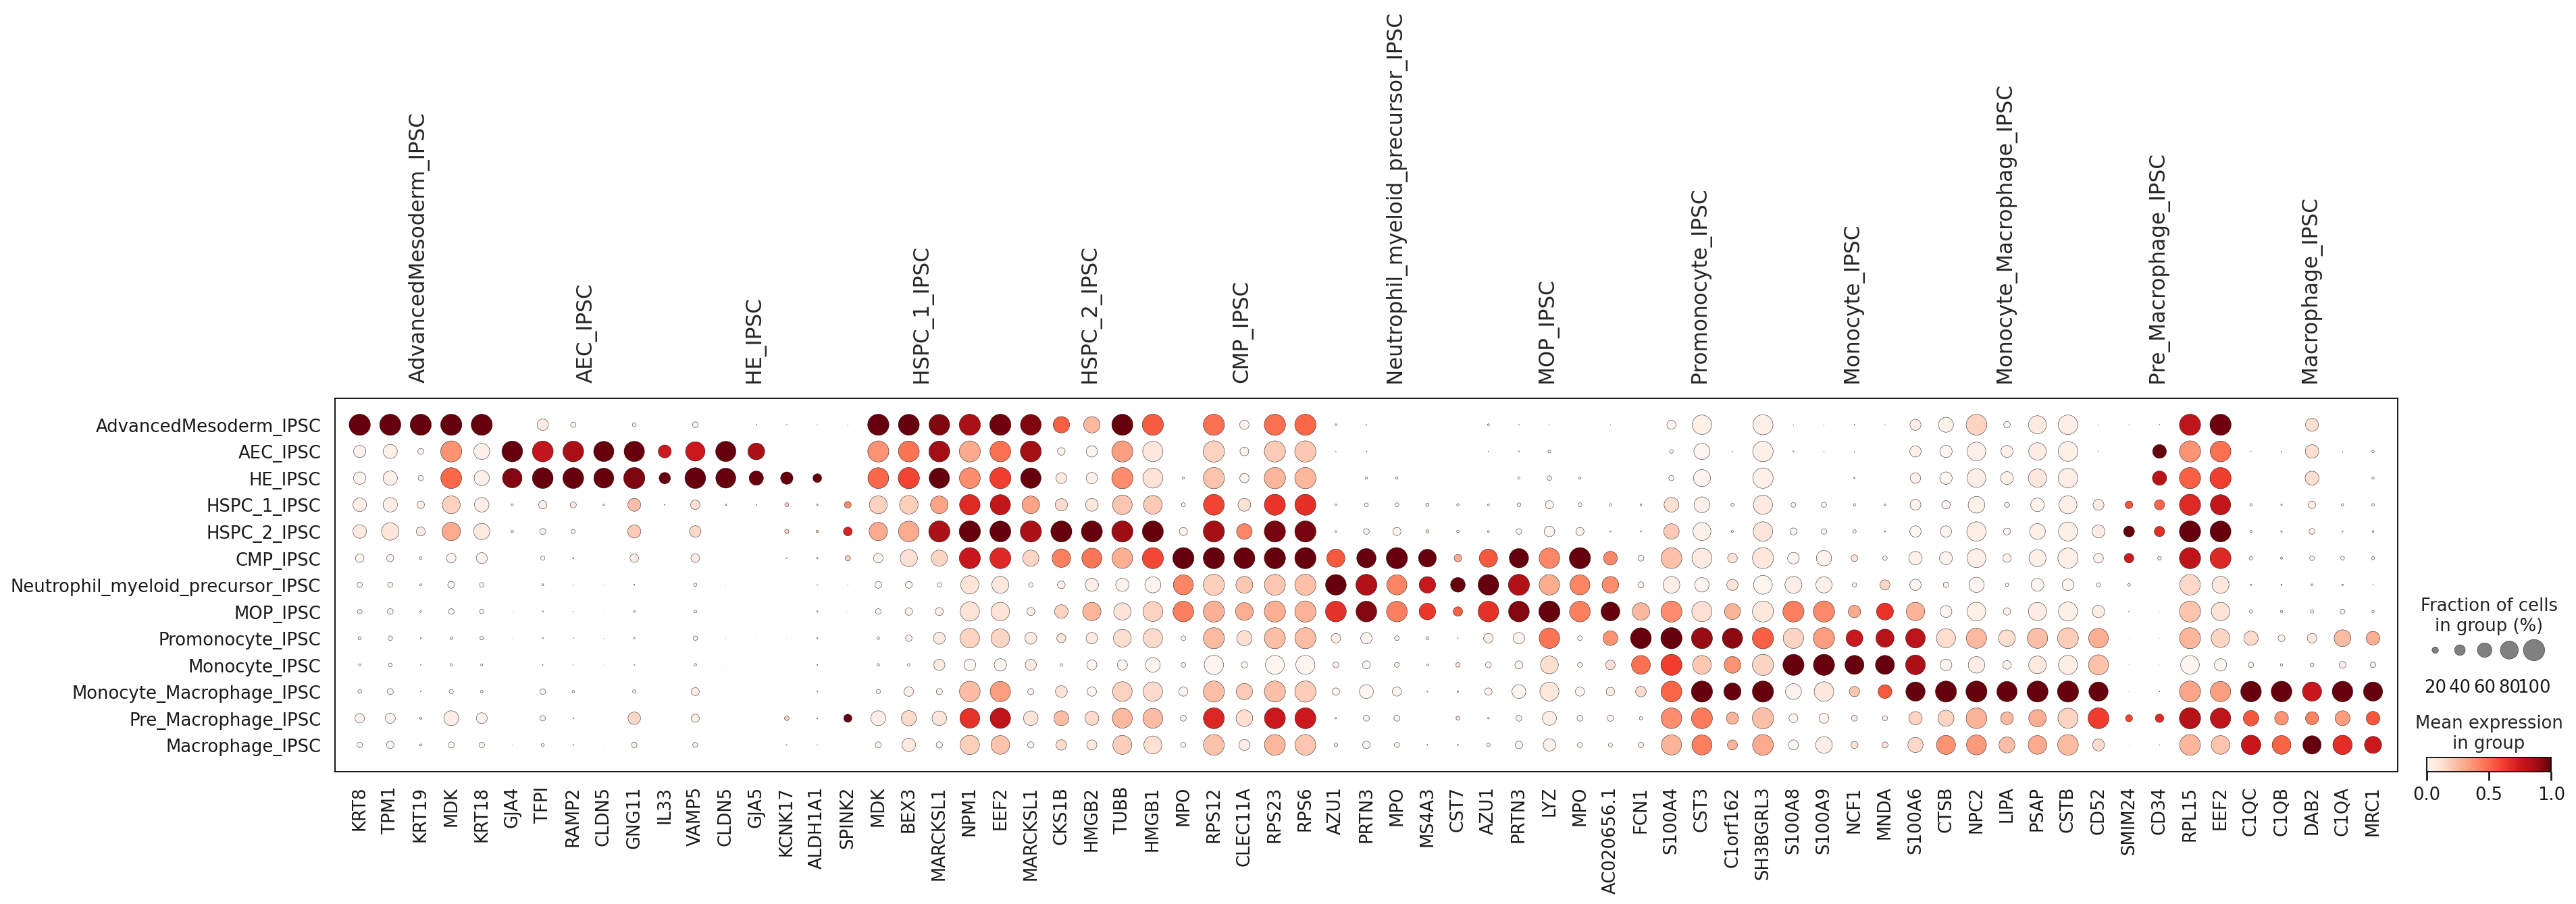

In [43]:
markers = {
'AdvancedMesoderm_IPSC': ['KRT8', 'TPM1', 'KRT19', 'MDK', 'KRT18'],
'AEC_IPSC': ['GJA4', 'TFPI', 'RAMP2', 'CLDN5', 'GNG11','IL33'],
 'HE_IPSC': ['VAMP5', 'CLDN5','GJA5', 'KCNK17', 'ALDH1A1'],
 'HSPC_1_IPSC': ['SPINK2','MDK', 'BEX3', 'MARCKSL1', 'NPM1', 'EEF2'],
 'HSPC_2_IPSC': ['MARCKSL1', 'CKS1B', 'HMGB2', 'TUBB', 'HMGB1'],
'CMP_IPSC': ['MPO', 'RPS12', 'CLEC11A', 'RPS23', 'RPS6'],
 'Neutrophil_myeloid_precursor_IPSC': ['AZU1','PRTN3','MPO','MS4A3','CST7'],
 'MOP_IPSC': ['AZU1', 'PRTN3', 'LYZ', 'MPO', 'AC020656.1'],
 'Promonocyte_IPSC': ['FCN1', 'S100A4', 'CST3', 'C1orf162', 'SH3BGRL3'],
 'Monocyte_IPSC': ['S100A8', 'S100A9', 'NCF1', 'MNDA', 'S100A6'],
 'Monocyte_Macrophage_IPSC': ['CTSB', 'NPC2', 'LIPA', 'PSAP', 'CSTB'],
 'Pre_Macrophage_IPSC': ['CD52', 'SMIM24', 'CD34', 'RPL15', 'EEF2'],
 'Macrophage_IPSC': ['C1QC', 'C1QB', 'DAB2', 'C1QA', 'APOC','MRC1'],
}
markers = markers
sc.pl.dotplot(adata, var_names = markers, groupby='LR_assignment_v2',dendrogram=False,standard_scale='var', color_map='Reds', show = True, save = 'diff_expression_v6_mac_lin.pdf') # title=i

# adata YS overall plot

In [12]:
spot_var = 'cell.labels'#'cell.labels'
sc.tl.rank_genes_groups(adata , spot_var, method='wilcoxon',n_genes=500)
sc.pl.rank_genes_groups(adata , n_genes=50, sharey=False)
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
    
DE = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals_adj','logfoldchanges']}).head(500)
DE_name ="./overall_fliv_YS_DEGS_044222.csv"

degs = DE[:]
if 'concat' in locals() or 'concat' in globals():
    del(concat)
n = degs.loc[:, degs.columns.str.endswith("_n")]
n = pd.melt(n)
p = degs.loc[:, degs.columns.str.endswith("_p")]
p = pd.melt(p)
l = degs.loc[:, degs.columns.str.endswith("_l")]
l = pd.melt(l)
n = n.replace(regex=r'_n', value='')
n = n.rename(columns={"variable": "cluster", "value": "gene"})
p = (p.drop(["variable"],axis = 1)).rename(columns={ "value": "pvals_adj"})
l = (l.drop(["variable"],axis = 1)).rename(columns={ "value": "logfc"})
concat = pd.concat([n,p,l],axis=1)
#remove mito genes from data
concat = concat[~concat["gene"].str.startswith("MT-")]
concat = concat[~concat["gene"].str.startswith("RP11-")]
concat["cluster"] = concat["cluster"].astype(str)
marker_df = concat.groupby('cluster').apply(lambda grp: grp.nlargest(20, 'logfc')).reset_index(drop=True)
marker_df = marker_df.groupby('cluster').apply(lambda grp: grp.nsmallest(3, 'pvals_adj')).reset_index(drop=True)
markers = marker_df.groupby('cluster')['gene'].apply(list).to_dict()
markers = dict(sorted(markers.items()))
markers = {str(k):v for k,v in markers.items()}
data_temp = adata 
markers = markers
(sc.pl.dotplot(data_temp, var_names = markers, groupby=spot_var,dendrogram=False, color_map='Reds', show = True,standard_scale='var',save= 'fliv_ys_DEGs'))

ranking genes


Trying to set attribute `.uns` of view, copying.


KeyError: 'corr_concat'

In [14]:
DE.to_csv(DE_name)

# Just HSPC1_HSPC2

In [13]:
concat = concat[concat['cluster'].isin(['HSPC_1','HSPC_2'])]

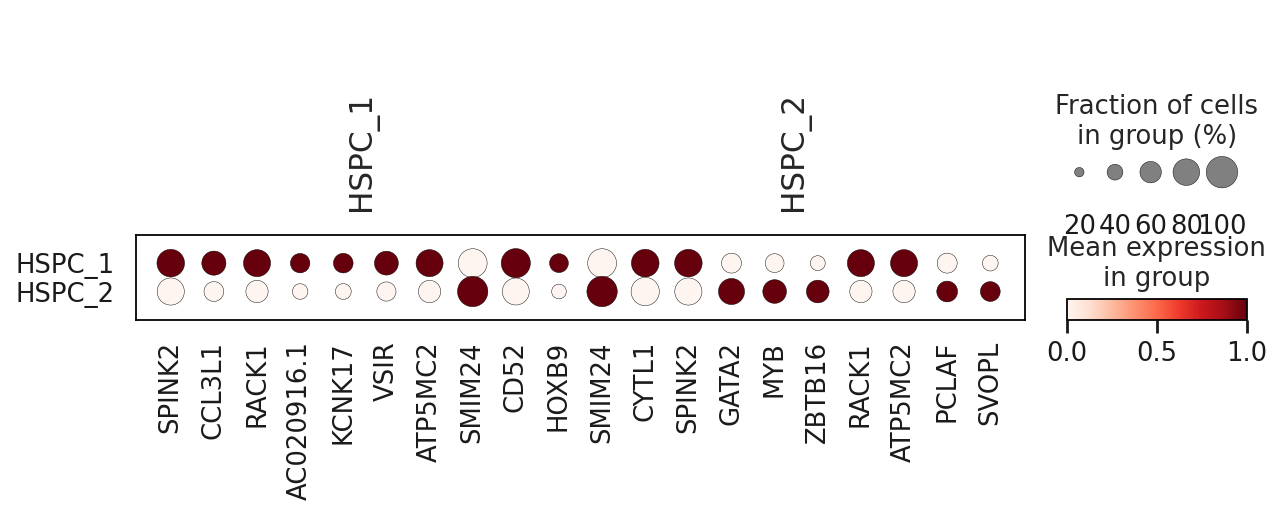

In [18]:
degs = DE[:]
if 'concat' in locals() or 'concat' in globals():
    del(concat)
n = degs.loc[:, degs.columns.str.endswith("_n")]
n = pd.melt(n)
p = degs.loc[:, degs.columns.str.endswith("_p")]
p = pd.melt(p)
l = degs.loc[:, degs.columns.str.endswith("_l")]
l = pd.melt(l)
n = n.replace(regex=r'_n', value='')
n = n.rename(columns={"variable": "cluster", "value": "gene"})
p = (p.drop(["variable"],axis = 1)).rename(columns={ "value": "pvals_adj"})
l = (l.drop(["variable"],axis = 1)).rename(columns={ "value": "logfc"})
concat = pd.concat([n,p,l],axis=1)
concat = concat[concat['cluster'].isin(['HSPC_1','HSPC_2'])]
#remove mito genes from data
concat = concat[~concat["gene"].str.startswith("MT-")]
concat = concat[~concat["gene"].str.startswith("RP11-")]
concat["cluster"] = concat["cluster"].astype(str)
#marker_df = concat.groupby('cluster').apply(lambda grp: grp.nlargest(10, 'logfc')).reset_index(drop=True)
marker_df = marker_df.groupby('cluster').apply(lambda grp: grp.nsmallest(10, 'pvals_adj')).reset_index(drop=True)
markers = marker_df.groupby('cluster')['gene'].apply(list).to_dict()
markers = dict(sorted(markers.items()))
markers = {str(k):v for k,v in markers.items()}
data_temp = adata 
markers = markers
data_temp = data_temp[data_temp.obs['cell.labels'].isin(['HSPC_1','HSPC_2'])]
(sc.pl.dotplot(data_temp, var_names = markers, groupby=spot_var,dendrogram=False, color_map='Reds', show = True,standard_scale='var',save= 'clotting_over_time'))

In [25]:
markers={'HSPC_1': ['SPINK2',
  'CCL3L1',
  'RACK1',
  'AC020916.1',
  'KCNK17',
  'VSIR',
  'ATP5MC2',
  'CD52',
  'HOXB9',  'CYTL1','RACK1',
  'ATP5MC2',],
 'HSPC_2': ['MKI67','TOP2A','PLK1','CDK1','GTSE1','SMIM24',
  'GATA2',
  'MYB',
  'ZBTB16',
  'PCLAF',
  'SVOPL']}

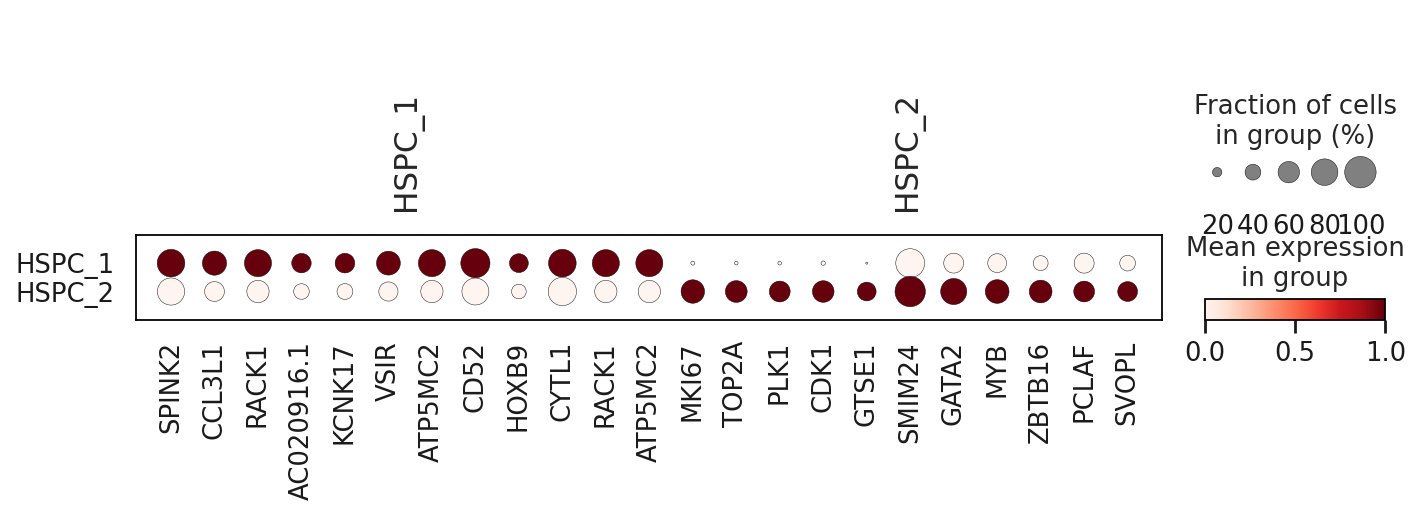

In [26]:
(sc.pl.dotplot(data_temp, var_names = markers, groupby=spot_var,dendrogram=False, color_map='Reds', show = True,standard_scale='var',save= 'clotting_over_time'))

In [6]:
DE_name ="./overall_YS_DEGS_170222.csv"

In [8]:
DE.to_csv(DE_name)